### NLP Research Internship Assignment Biomedical Text Analysis
*data_extraction_starter.ipynb*

In [49]:
# Import necessary libraries
from Bio import Entrez
import ssl
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Bypass SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

[nltk_data] Downloading package stopwords to /home/mahshy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mahshy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
# Function to fetch abstracts from PubMed using MeSH terms
def fetch_abstracts(term, max_results=100000):
    """
    Fetch abstracts from PubMed based on search terms.
    
    Parameters:
    term (str): Search term or MeSH term for querying PubMed.
    max_results (int): Maximum number of results to fetch.
    
    Returns:
    list: A list of abstracts fetched from PubMed.
    """
    
    # Provide contact email for Entrez
    Entrez.email = "info@toxgensolutions.eu"
    
    # Perform the search query using Entrez
    handle = Entrez.esearch(db="pubmed", term=term, retmax=max_results)
    
    # Read search results
    record = Entrez.read(handle)
    handle.close()
    
    # Extract PubMed IDs from the search results
    id_list = record["IdList"]
    
    # Check if search returned results
    if not id_list:
        print("No results found.")
        return []
    
    # Fetch abstracts based on PubMed IDs
    handle = Entrez.efetch(db="pubmed", id=id_list, rettype="abstract", retmode="text")
    
    # Read and split the abstracts
    abstracts = handle.read().split("\n\n")
    handle.close()
    
    return abstracts

In [51]:
# Define the search term, e.g., "Cancer Immunotherapy"
search_term = "Artificial Intelligence in Healthcare"

# Fetch abstracts using the search term
abstracts = fetch_abstracts(search_term)

# Display first 5 abstracts for quick inspection (optional)
print("First 5 abstracts:\n")
for i, abstract in enumerate(abstracts[:5]):
    print(f"{i+1}. {abstract}\n")

First 5 abstracts:

1. 1. Int J Radiat Oncol Biol Phys. 2023 Oct 1;117(2S):e687. doi: 
10.1016/j.ijrobp.2023.06.2156.

2. First Implementation of Full-Workflow Automation for Online Adaptive 
Radiotherapy of Nasopharyngeal Carcinoma.

3. Lin L(1), Zhou GQ(2), Yang X(1), Yang YX(1), Jiang X(2), Li B(3), Chen AQ(2), 
Diao WC(2), Liu L(2), He SM(4), Li H(5), Jia LC(5), Zhang W(3), Zhou J(3), Sun 
Y(6).

4. Author information:
(1)Sun Yat-sen University Cancer Center; State Key Laboratory of Oncology in 
South China; Collaborative Innovation Center for Cancer Medicine; Guangdong Key 
Laboratory of Nasopharyngeal Carcinoma Diagnosis and Therapy, Guangzhou, 
Guangdong, 510060, Guangzhou, China.
(2)Sun Yat-sen University Cancer Center, Guangzhou, China.
(3)Shanghai United Imaging Healthcare Co., Ltd., Shanghai, China.
(4)United Imaging Research Institute of Intelligent Imaging, Beijing, China.
(5)Shenzhen United Imaging Research Institute of Innovative Medical Equipment, 
Shenzhen, China.
(6)S

## Cleaning and preprocessing data

In [52]:

# remove meta data out of text
def remove_metadata(text):
    return [line for line in text if not re.match(r'^\d+\.',line)]


# Tokenization, stopwords removal, and stemming
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # remove special characters and extra spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Convert text to lowercase
    cleaned_text = cleaned_text.lower()
    
     # Tokenize the text into words
    tokens = nltk.word_tokenize(cleaned_text)
    
    # Remove stopwords
    tokens = [stemmer.stem(word) for word in tokens if word.lower() not in stop_words]
    
    # Join the words back into a cleaned text
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# select introduction out of test 
def select_introduction(abstracts):
    cleaned_abstracts = []
    for abstract in abstracts:
        if abstract[:12] == 'INTRODUCTION':
            cleaned_abstracts.append(abstract)
    return cleaned_abstracts



In [53]:
abstracts_no_meta = remove_metadata(abstracts)
cleaned_abstracts = [preprocess_text(abstract) for abstract in abstracts_no_meta]
cleaned_abstracts

['first implement fullworkflow autom onlin adapt radiotherapi nasopharyng carcinoma',
 'lin l1 zhou gq2 yang x1 yang yx1 jiang x2 li b3 chen aq2 diao wc2 liu l2 sm4 li h5 jia lc5 zhang w3 zhou j3 sun y6',
 'author inform 1sun yatsen univers cancer center state key laboratori oncolog south china collabor innov center cancer medicin guangdong key laboratori nasopharyng carcinoma diagnosi therapi guangzhou guangdong 510060 guangzhou china 2sun yatsen univers cancer center guangzhou china 3shanghai unit imag healthcar co ltd shanghai china 4unit imag research institut intellig imag beij china 5shenzhen unit imag research institut innov medic equip shenzhen china 6state key laboratori oncolog south china collabor innov center cancer medicin sun yatsen univers cancer center guangzhou china',
 'purposeobject aim work establish technic characterist implement procedur artifici intellig aipow radiotherapi workflow enabl fullprocess autom onlin adapt radiotherapi art evalu feasibl perform impleme

## Advanced NLP analysis
1.General Keyword Extraction
2.Topic Modeling and Keyword Extraction

### General Keyword Extraction

In [54]:
# import necessary lib
from sklearn.feature_extraction.text import TfidfVectorizer


In [55]:
# General Keyword Extraction

# for getting keywords only introduction of each research will be checked
intro_abstracts = select_introduction(abstracts)
cleaned_intro_abstracts = [preprocess_text(abstract) for abstract in intro_abstracts]


# convert the clean abstracts "Introduction into TF-IDF feature vectors"
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20, min_df=2, stop_words='english')
# Create TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_intro_abstracts)
# Get feature names (terms)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()
top_keywords_per_abstract = []


for i, abstract in enumerate(cleaned_intro_abstracts):
    tfidf_scores_for_abstract = tfidf_scores[i]
    top_keywords_indices = tfidf_scores_for_abstract.argsort()[-5:][::-1]  # Get the top 5 keywords
    top_keywords = [feature_names[idx] for idx in top_keywords_indices]
    top_keywords_per_abstract.append(top_keywords)

In [56]:
for i, keywords in enumerate(top_keywords_per_abstract):
    print(f"Abstract {i+1} Keywords: {', '.join(keywords)}")

Abstract 1 Keywords: health, result, develop, use, method
Abstract 2 Keywords: ai, healthcar, studi, develop, result
Abstract 3 Keywords: studi, clinic, includ, healthcar, data
Abstract 4 Keywords: imag, clinic, learn, model, use
Abstract 5 Keywords: data, use, predict, model, medic
Abstract 6 Keywords: clinic, use, method, includ, studi
Abstract 7 Keywords: data, clinic, medic, health, studi
Abstract 8 Keywords: ai, healthcar, clinic, care, patient
Abstract 9 Keywords: imag, ai, care, use, studi
Abstract 10 Keywords: model, patient, use, clinic, predict
Abstract 11 Keywords: predict, healthcar, result, medic, use
Abstract 12 Keywords: ai, predict, medic, perform, studi
Abstract 13 Keywords: ai, medic, learn, use, imag
Abstract 14 Keywords: medic, care, studi, result, learn
Abstract 15 Keywords: data, includ, use, method, studi
Abstract 16 Keywords: care, health, use, learn, develop
Abstract 17 Keywords: patient, method, studi, perform, use
Abstract 18 Keywords: healthcar, perform, ima

In [57]:
# Create an empty dictionary to store word counts
flattened_list = [item for sublist in top_keywords_per_abstract for item in sublist]
word_count = {}

# Loop through the words and count their occurrences
for word in flattened_list:
    if word in word_count:
        word_count[word] += 1
    else:
        word_count[word] = 1

# Print the word counts
for word, count in word_count.items():
    print(f'{word}: {count}')

health: 83
result: 61
develop: 63
use: 157
method: 46
ai: 68
healthcar: 77
studi: 110
clinic: 97
includ: 65
data: 90
imag: 45
learn: 67
model: 92
predict: 74
medic: 61
care: 69
patient: 120
perform: 69
introduct: 6


# Topic Modeling and Keyword Extraction

In [58]:
# Apply Topic Modeling LDA:
from gensim.models import CoherenceModel

# Initialize LDA model
num_topics = 10  # adjust this number 
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit LDA model to TF-IDF matrix
lda_model.fit(tfidf_matrix)

# Get the document-topic matrix
doc_topic_matrix = lda_model.transform(tfidf_matrix)

# Get the topic-term matrix
topic_term_matrix = lda_model.components_

In [62]:
num_top_words = 30  # Adjust the number of top words as needed
for topic_idx, topic in enumerate(topic_term_matrix):
    top_words_idx = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: health, develop, use, method, result, introduct, studi, medic, healthcar, perform, model, data, includ, clinic, predict, patient, ai, learn, care, imag
Topic 2: model, learn, use, develop, result, healthcar, studi, method, introduct, data, patient, perform, health, care, includ, medic, ai, clinic, predict, imag
Topic 3: care, health, use, clinic, studi, data, medic, healthcar, method, perform, result, includ, patient, develop, introduct, learn, model, predict, ai, imag
Topic 4: model, medic, patient, perform, healthcar, predict, includ, introduct, method, develop, result, studi, use, data, ai, learn, clinic, health, care, imag
Topic 5: predict, model, patient, use, data, clinic, learn, perform, studi, develop, result, method, includ, healthcar, introduct, medic, health, care, imag, ai
Topic 6: imag, use, perform, clinic, method, learn, ai, result, studi, develop, data, model, introduct, includ, medic, predict, patient, healthcar, care, health
Topic 7: patient, studi, use, clin

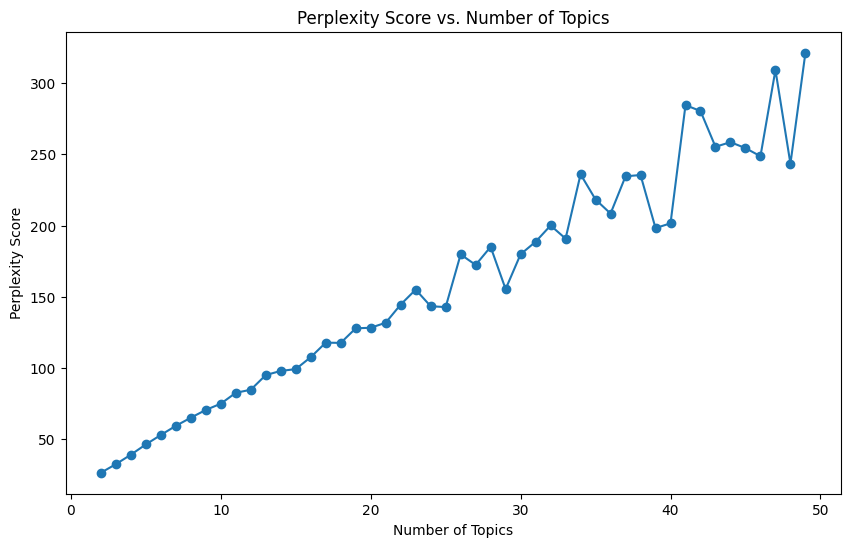

In [63]:
# Create a list to store perplexity scores
perplexity_scores = []

# Try different numbers of topics
num_topics_range = range(2, 50)  # Adjust the range as needed
for num_topics in num_topics_range:
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(tfidf_matrix)  # Use your TF-IDF matrix here
    
    # Calculate perplexity
    perplexity_score = lda_model.perplexity(tfidf_matrix)
    
    perplexity_scores.append(perplexity_score)

# Plot perplexity scores to find the optimal number of topics
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, perplexity_scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.title("Perplexity Score vs. Number of Topics")
plt.show()
